In [2]:
%reload_ext autoreload
%autoreload 2


In [3]:
from dataset.visualgenome import VisualGenomeDataset

config_path = "/u/h/k/hkhader/research/OLIVE/configs/relationships_retrieval.yaml"
import yaml

def load_config(file_path):
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

config = load_config(config_path) 
config['device'] = 'cuda:0'
#config['retrieval_set_path'] = "/home/hkhader/research/datasets/outputs/olive/retrieval/relation_prediction/100images_retrieval_set_1000000_clip-vit-large-patch14-336.pkl"


/nobackup2/hkhader/miniconda/envs/olive/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
ginome_dataset = VisualGenomeDataset(config, patch_size=config['n_patches'], images_num=None, entries_num=400000, split="train")

/nobackup2/hkhader/miniconda/envs/olive/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for visual_genome contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/visual_genome
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|██████████| 86461/86461 [09:23<00:00, 153.49it/s]


Skipped over 106119 bad pairs (no pixels)
Loaded 2002869 examples from /home/hkhader/research/datasets/outputs/olive/retrieval/relation_prediction/retrieval_set_1000000_clip-vit-large-patch14-336.pkl


In [5]:
len(ginome_dataset.retrieval_entries), len(ginome_dataset.retrieval_keys), len(ginome_dataset.retrieval_labels), len(ginome_dataset.retrieval_idx)

(2002869, 2002869, 2002869, 2002869)

In [6]:
max(ginome_dataset.retrieval_idx)

2002868

In [11]:
import torch

In [18]:
import cProfile
import pstats
import io

def profile_retrieval():
    retrieved = ginome_dataset.retrieve_closest(ginome_dataset.retrieval_keys[990:1000], 5, train_phase=False)

# Profile the retrieval function
profiler = cProfile.Profile()
profiler.enable()
profile_retrieval()
profiler.disable()

# Output the profiling results
stream = io.StringIO()
stats = pstats.Stats(profiler, stream=stream).sort_stats(pstats.SortKey.TIME)
stats.print_stats()

# Print the results to the console
print(stream.getvalue())

Exception ignored When destroying _lsprof profiler:
Traceback (most recent call last):
  File "/tmp/ipykernel_3500763/510177899.py", line 10, in <module>
RuntimeError: Cannot install a profile function while another profile function is being installed


         574 function calls in 0.479 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       10    0.366    0.037    0.366    0.037 {method 'tolist' of 'torch._C._TensorBase' objects}
       10    0.090    0.009    0.456    0.046 /home/hkhader/research/OLIVE/dataset/visualgenome.py:135(select_different_images)
        1    0.019    0.019    0.479    0.479 /home/hkhader/research/OLIVE/dataset/visualgenome.py:158(retrieve_closest)
       50    0.001    0.000    0.001    0.000 /home/hkhader/research/OLIVE/dataset/visualgenome.py:174(retrieve_info)
        1    0.001    0.001    0.001    0.001 {built-in method torch.argsort}
       10    0.001    0.000    0.001    0.000 /home/hkhader/research/OLIVE/dataset/visualgenome.py:170(<listcomp>)
        1    0.000    0.000    0.457    0.457 /home/hkhader/research/OLIVE/dataset/visualgenome.py:150(<listcomp>)
        1    0.000    0.000    0.000    0.000 {built-in method torch.tensor}
  

In [20]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def overlay_masks_on_first_image(image, masks):
    image_as_tensor = transforms.ToTensor()(image)  # Add batch dimension
    image_numpy = image_as_tensor.permute(1, 2, 0).numpy()  # Remove batch dimension and permute for visualization

    # Step 4: Loop over all the masks and overlay them on the image
    masks_overlasy = []
    for i, mask in enumerate(masks):
        # Step 5: Convert mask to a PIL image and resize to the size of the image
        import math
        patches = int(math.sqrt(len(mask[1:])))
        mask_tensor = torch.tensor(mask[1:], dtype=torch.float32).view(patches, patches).view(1,1, patches, patches)  # H*W 
        import torch.nn.functional as F
        mask_resized = F.interpolate(mask_tensor, size=image_as_tensor.shape[1:], mode='nearest').squeeze(0).repeat(3, 1, 1)
        mask_numpy = mask_resized.permute(1, 2, 0).numpy() 
        masks_overlasy.append(mask_numpy)

    
    mask1, mask2 = masks_overlasy
    overlay = (1 - mask1)*image_numpy + 0.5 * mask1 * [0.5, 0, 0]  + 0.5 * mask1*image_numpy
    overlay = (1 - mask2)*overlay + 0.5 * mask2 * [0, 0, 0.5]  + 0.5 * mask2*overlay
    
    plt.imshow(overlay)
    plt.axis('off')  # Hide axes

    plt.show()



In [ ]:
retrieved = ginome_dataset.retrieve_closest(ginome_dataset.retrieval_keys[100:101], 5, train_phase=True)
torch.cuda.empty_cache()

# Example usage:
for i in range(5):
    sample = retrieved[0][0][i]
    overlay_masks_on_first_image(sample['path_to_image'], [sample['vit_mask']]*2 )
    print(sample["answer"])


NameError: name 'overlay_masks_on_first_image' is not defined

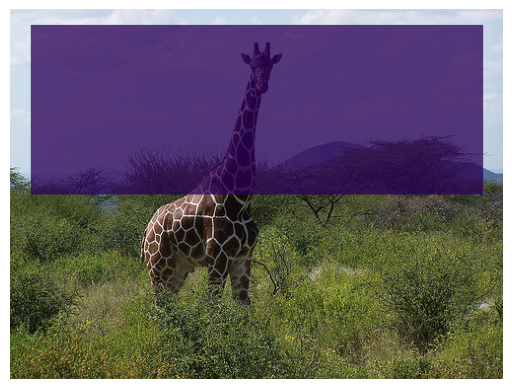

sky


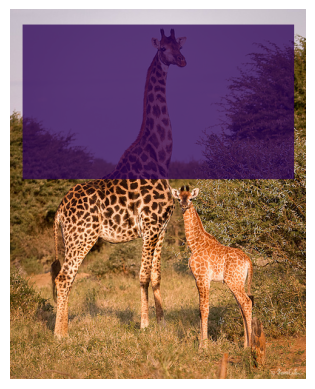

sky


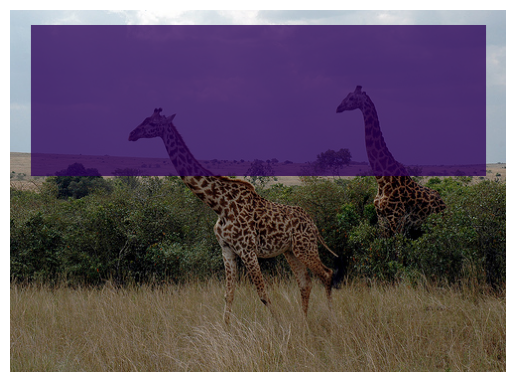

sky


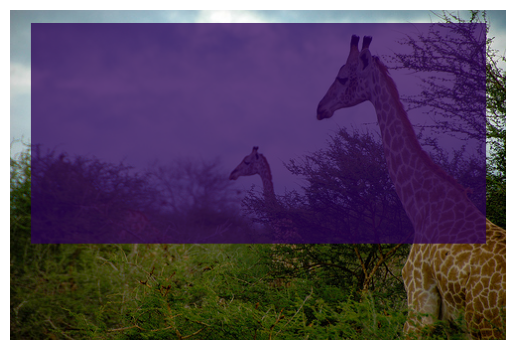

sky


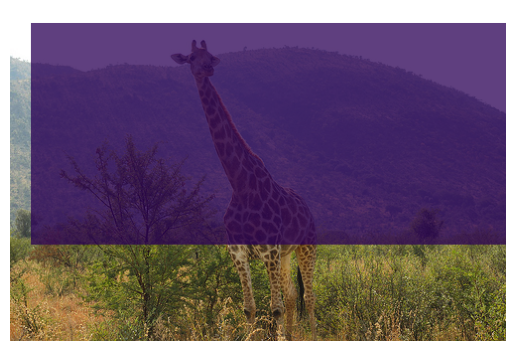

background


In [21]:
retrieved = ginome_dataset.retrieve_closest(ginome_dataset.retrieval_keys[100:101], 5, train_phase=False)

# Example usage:
for i in range(5):
    sample = retrieved[0][0][i]
    overlay_masks_on_first_image(sample['path_to_image'], [sample['vit_mask']]*2 )
    print(sample["answer"])


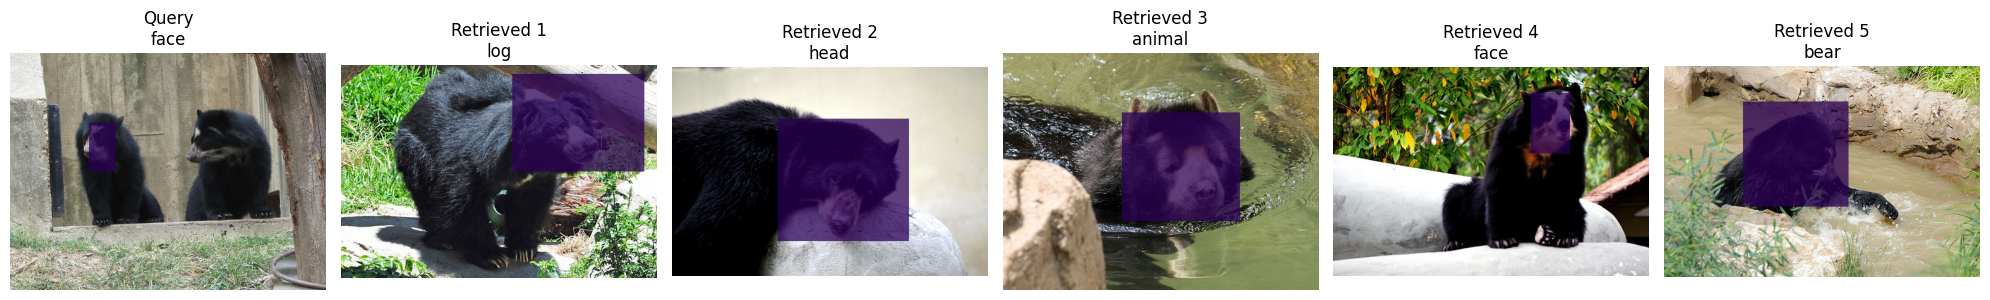

In [58]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
import torch.nn.functional as F

def overlay_masks_on_first_image(image, masks):
    image_as_tensor = transforms.ToTensor()(image)  # Convert image to tensor
    image_numpy = image_as_tensor.permute(1, 2, 0).numpy()  # Permute for visualization

    # Overlay masks
    masks_overlay = []
    for mask in masks:
        patches = int(math.sqrt(len(mask[1:])))
        mask_tensor = torch.tensor(mask[1:], dtype=torch.float32).view(patches, patches).unsqueeze(0).unsqueeze(0)
        mask_resized = F.interpolate(mask_tensor, size=image_as_tensor.shape[1:], mode='nearest').squeeze(0).repeat(3, 1, 1)
        mask_numpy = mask_resized.permute(1, 2, 0).numpy()
        masks_overlay.append(mask_numpy)

    # Combine masks into a single overlay
    overlay = image_numpy
    colors = [[0.5, 0, 0], [0, 0, 0.5]]  # Colors for masks
    for i, mask in enumerate(masks_overlay):
        overlay = (1 - mask) * overlay + 0.5 * mask * colors[i] + 0.5 * mask * overlay

    return overlay

# Display the query image and top 5 retrieved images
# 101 good example.
idx = 56223
retrieved = ginome_dataset.retrieve_closest(ginome_dataset.retrieval_keys[idx:idx+1], 6, train_phase=False)

# Initialize a figure
fig, axes = plt.subplots(1, 6, figsize=(20, 5))  # 1 row, 6 columns (query + 5 retrieved)
axes = axes.flatten()

# Display the query image
query_sample = retrieved[0][0][0]
query_image = query_sample['path_to_image']
overlay = overlay_masks_on_first_image(query_image, [query_sample['vit_mask']] * 2)
axes[0].imshow(overlay)
axes[0].set_title(f"Query\n{query_sample['answer']}")

axes[0].axis('off')

# Display retrieved images
for i in range(5):
    sample = retrieved[0][0][i+1]
    retrieved_image = sample['path_to_image']
    overlay = overlay_masks_on_first_image(retrieved_image, [sample['vit_mask']] * 2)
    axes[i + 1].imshow(overlay)
    axes[i + 1].set_title(f"Retrieved {i + 1}\n{sample['answer']}")
    axes[i + 1].axis('off')

plt.tight_layout()
plt.show()


In [59]:
def evaluate_majority_vote(dataset, num_keys=3, num_closest=6):
    correct_count = 0
    from tqdm import tqdm
    import random 
    for i in tqdm(range(num_keys)):
        key_idx = random.randint(0, dataset.retrieval_keys.shape[0]-1)
        # Retrieve the closest objects
        retrieved = dataset.retrieve_closest(dataset.retrieval_keys[key_idx:key_idx+1], num_closest, train_phase=False)
        
        # Query sample and its label
        query_sample = retrieved[0][0][0]
        query_label = query_sample["answer"]
        
        # Labels of the retrieved samples (excluding the query itself)
        retrieved_labels = [retrieved[0][0][i]["answer"] for i in range(1, num_closest)]

        # Majority vote among the retrieved labels
        majority_label = max(set(retrieved_labels), key=retrieved_labels.count)

        # Check if majority label matches the query label
        if majority_label == query_label:
            correct_count += 1

    # Compute and print the average accuracy
    average_accuracy = correct_count / num_keys
    print(f"Average accuracy over {num_keys} keys: {average_accuracy:.2%}")

# Run the evaluation
full_keys_count = ginome_dataset.retrieval_keys.shape[0]
evaluate_majority_vote(ginome_dataset, num_keys=15000, num_closest=6)


100%|██████████| 15000/15000 [14:11<00:00, 17.61it/s]

Average accuracy over 15000 keys: 18.09%


In [37]:
ginome_dataset.retrieval_keys.shape[0]

2002869